# Seasonality



In [105]:
# Import all packages

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

# Set the file where your data is located

file = "https://raw.githubusercontent.com/omercadopopular/cgoes/master/tutorial/python/Time%20Series/2.%20Stationary%20and%20Non-Stationary%20Series/totalrealearningsbrazil.csv"

# Read the data

data = pd.read_csv(file, header=0, sep=';')

#Format the date and set the index

data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.set_index('Date')

# Format the headers

data.columns = map(str.lower, data.columns)

# Create a list with all the cities

cities = list(data[:1])

# Create variables for days, months, and years

data['day'] = data.index.strftime('%d')
data['month'] = data.index.strftime('%b')
data['year'] = data.index.year

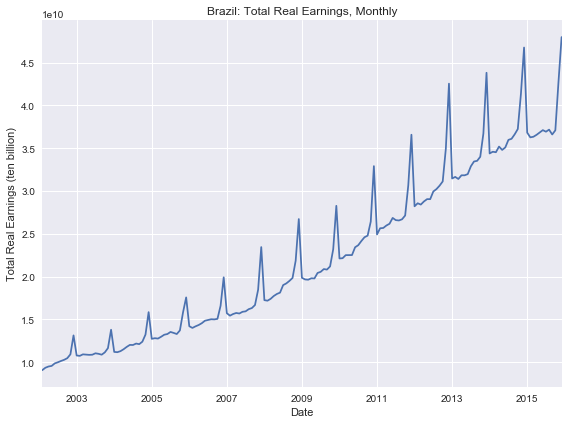

In [106]:
# Plot the monthly data

fig, ax = plt.subplots(figsize=(8,6))
data['total'].plot(ax=ax)
ax.set_title('Brazil: Total Real Earnings, Monthly')
ax.set_ylabel('Total Real Earnings (ten billion)')    
ax.set_xlabel('Date')
fig.tight_layout()


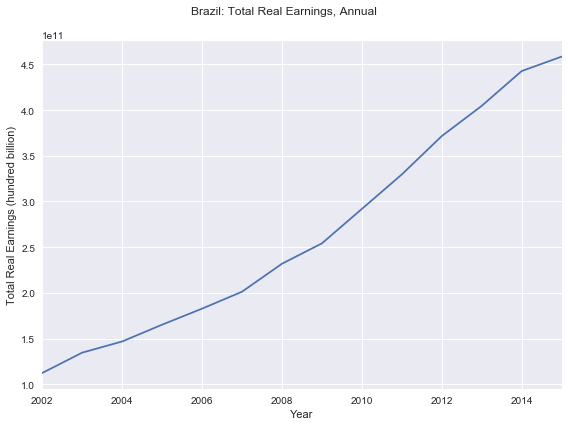

In [107]:
# Let's see how it looks like in annual aggregates

fig, ax = plt.subplots(figsize=(8,6));
data['total'].resample('AS').sum().plot(ax=ax) #MS,QS,AS
fig.suptitle('Brazil: Total Real Earnings, Annual');
ax.set_ylabel('Total Real Earnings (hundred billion)');
ax.set_xlabel('Year');
fig.tight_layout();
fig.subplots_adjust(top=0.9)


In [108]:
# Let's correct the seasonality

# Linearize the data (if needed)
data['ltotal'] = np.log(data['total'])

# Create any linear trend
data['trend'] = [i+1 for i in range(data['ltotal'].count())]

# Regress the trend on the series
lm  = smf.ols('ltotal ~ trend', data=data).fit(cov_type='HC3')
print(lm.summary())

# Your predicted value is the scaled linear trend
data['trend'] = lm.predict()

# While your residuals are the "detrended" series
data['detrend'] = lm.resid

                            OLS Regression Results                            
Dep. Variable:                 ltotal   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     5129.
Date:                Sat, 25 Mar 2017   Prob (F-statistic):          3.37e-126
Time:                        05:01:55   Log-Likelihood:                 183.60
No. Observations:                 167   AIC:                            -363.2
Df Residuals:                     165   BIC:                            -357.0
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     22.9683      0.011   2080.433      0.0

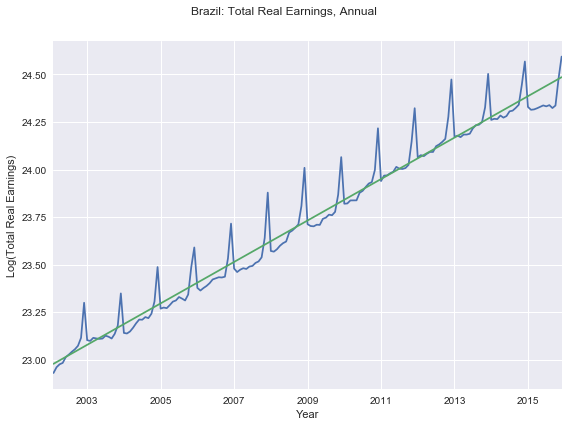

In [109]:
#Plot the trend and the actual series
    
fig, ax = plt.subplots(figsize=(8,6));
data['ltotal'].plot(ax=ax)
data['trend'].plot(ax=ax)
fig.suptitle('Brazil: Total Real Earnings, Annual');
ax.set_ylabel('Log(Total Real Earnings)');
ax.set_xlabel('Year');
fig.tight_layout();
fig.subplots_adjust(top=0.9)
plt.show()

In [110]:
# Now let's regress the detrended series and dummies for each month

lm = smf.ols('detrend ~ month', data=data).fit(cov_type='HC3')
print(lm.summary())

# The residuals are the detrended, deseasonalized series
    # The intution is: is the detrended series
    # above the average for that month? If so, it is really above average.
    # Else, it is not, and all we see is the seasonal effect.

data['deseason'] = lm.resid

                            OLS Regression Results                            
Dep. Variable:                detrend   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     31.69
Date:                Sat, 25 Mar 2017   Prob (F-statistic):           3.05e-34
Time:                        05:01:56   Log-Likelihood:                 331.49
No. Observations:                 167   AIC:                            -639.0
Df Residuals:                     155   BIC:                            -601.6
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -0.0324      0.008     -4.304   

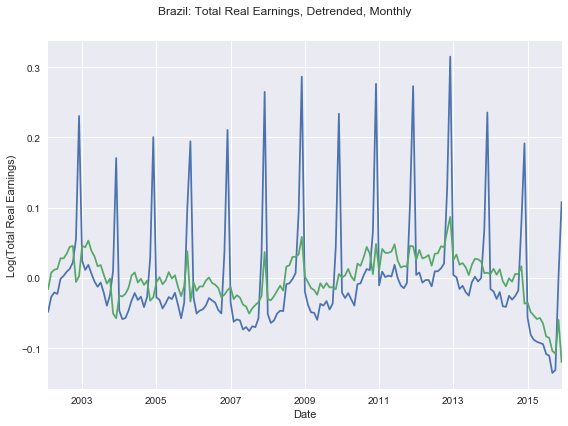

In [111]:
# Let's plot the deseasonalized series against a non-deseasonalized
    #series
    
fig, ax = plt.subplots(figsize=(8,6));
data['detrend'].plot(ax=ax)
data['deseason'].plot(ax=ax)
fig.suptitle('Brazil: Total Real Earnings, Detrended, Monthly');
ax.set_ylabel('Log(Total Real Earnings)');
ax.set_xlabel('Date');
fig.tight_layout();
fig.subplots_adjust(top=0.9)

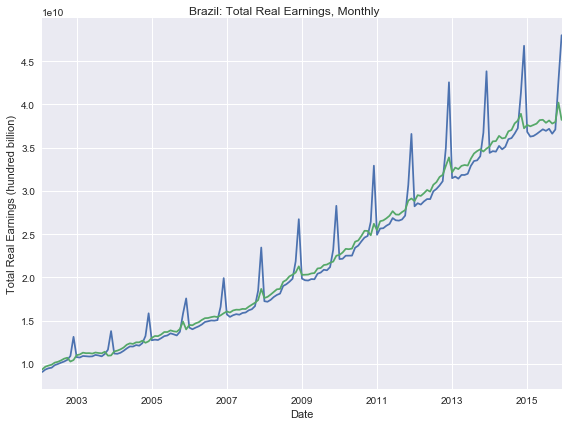

In [112]:
# Finally, let's use the scaled trend to "retrend" the series
    # and compare it to the unadjusted series

data['retrend'] = np.exp(data['deseason'] + data['trend'])

fig, ax = plt.subplots(figsize=(8,6));
data['total'].plot(ax=ax)
data['retrend'].plot(ax=ax)
fig.suptitle('Brazil: Total Real Earnings, Monthly');
ax.set_ylabel('Total Real Earnings (hundred billion)');
ax.set_xlabel('Date');
legend = ax.get_legend();
fig.tight_layout();

In [113]:
# Now let's create a program to make it easy
# to conduct seasonal adjustment for all cities

def deseason(k,df,season):
    lk = np.log(df[k])
    trend = [i+1 for i in range(lk.count())]
    trend = sm.add_constant(trend)
    trend = sm.OLS(lk, trend).fit().predict(trend)
    detrend = lk - trend
    dummy = sm.tools.categorical(np.asarray(df[season]), drop=True)
    dummy = sm.add_constant(dummy)
    deseason = detrend - sm.OLS(detrend, dummy).fit().predict(dummy)
    retrend = np.exp(deseason + trend)
    return retrend

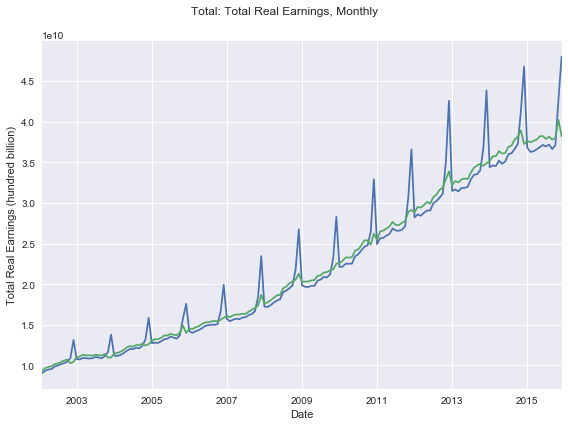

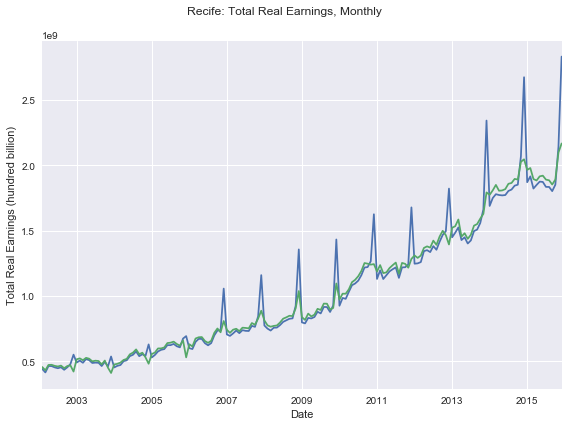

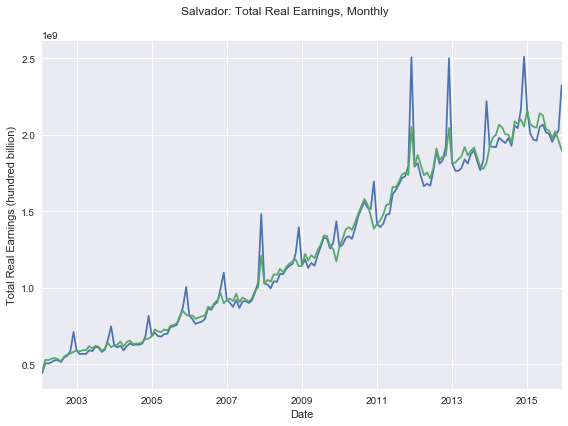

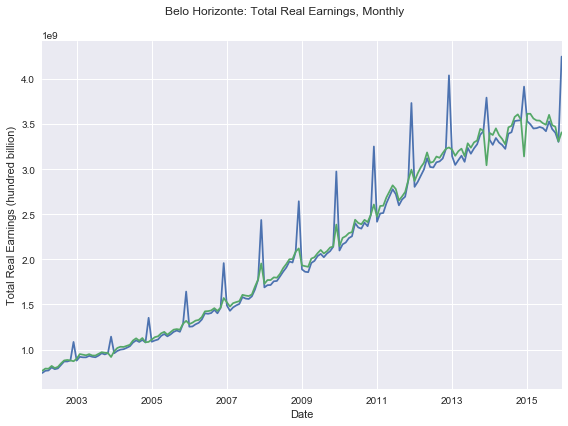

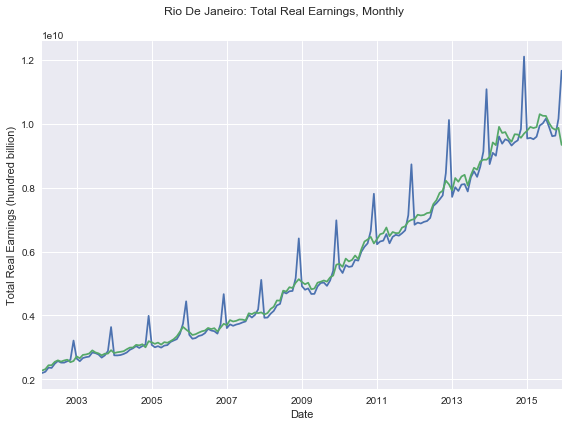

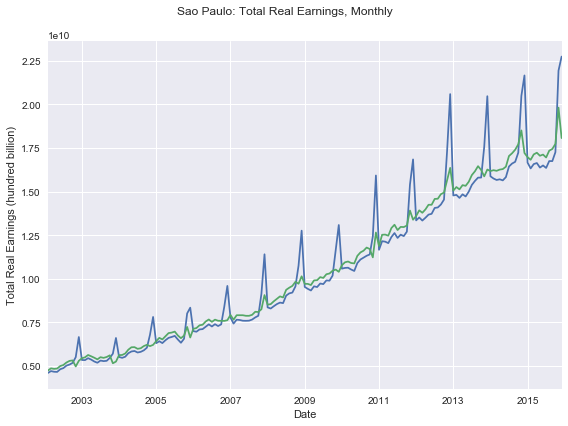

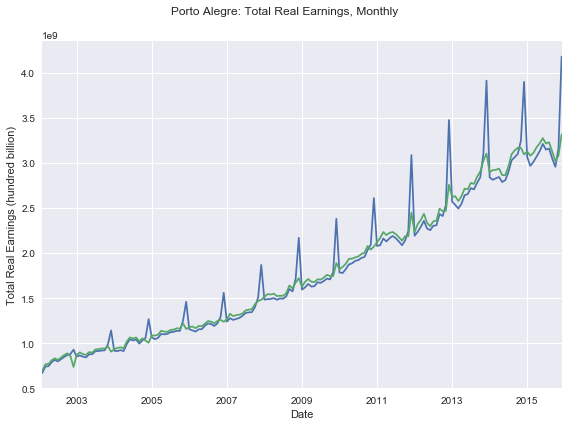

In [114]:
# And let's apply it to all of them

results = dict()

for city in cities:
    results[city] = deseason(city,data,'month')
    fig, ax = plt.subplots(figsize=(8,6));
    data[city].plot(ax=ax)
    results[city].plot(ax=ax)
    fig.suptitle(city.title() + ': Total Real Earnings, Monthly');
    ax.set_ylabel('Total Real Earnings (hundred billion)');
    ax.set_xlabel('Date');
    legend = ax.get_legend();
    fig.tight_layout();
    fig.subplots_adjust(top=0.9)